In [21]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sps
import random
import time
import itertools
from itertools import repeat
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map



In [28]:
def load_data_into_matrix_test(filename):
    #selected_index = np.random.randint(0,65225506,100000)
    # pls un comment the index selection for choosing the whole data set
    data = np.load(filename)[:5000000] #select only the first 5e6 rows
    ## each row represents each user, and each column for each movie
    input_matrix = sps.coo_matrix((data[:,2],(data[:,0]-1,data[:,1]-1)),
                                  shape=(data[:,0].max(),data[:,1].max()),dtype=np.int8)
    
    return input_matrix



def JS_sign(per_num,input_matrix):
    '''
    The frist method used for generating the signature matrix. We read 
    the ratings for user[j] following the permutation[i] order using the for loop
    and take the index of the first rating we meet as the signature[i][j]
    '''
    
    permutations = np.array([np.random.permutation(len(input_matrix[0])) for i in range(per_num)])
    sign = np.full((per_num, len(input_matrix)), np.inf)
#     sign2 = np.full((per_num, len(input_matrix)), np.inf)
    for i in tqdm(range(per_num)):
#         permutation = np.random.permutation(len(input_matrix[0]))
#         print(permutation)
        ## get the indeices that would sort the permutation arrays in order to access the ratings following
        ## the permutation order.
        per_index = permutations[i].argsort()
        for j in range (len(input_matrix)):
#             sign2[i][j] = np.min(input_matrix[j][per_index].nonzero()[0])
            while sign[i][j] == np.inf:
                for k in range (len(permutations[i])):
                    ## go through every line of the input matrix using permutation order
                    if input_matrix[j][per_index[k]] != 0:
                        sign[i][j] = k
                        break
        
    return sign

def JS_sign2(per_num,input_matrix):
    '''
    The second method used for generating the signature matrix. It first returns the ratings for
    user j as an array in the permutation i order, and we select the minimum index of the non zero
    value of the array after permutation as the value we give to signature matrix[i][j].
    '''
    permutations = np.array([np.random.permutation(len(input_matrix[0])) for i in range(per_num)])
    sign = np.full((per_num, len(input_matrix)), np.nan)
    for i in tqdm(range (permutations)):
        
        ## get the indeices that would sort the permutation arrays in order to access the ratings following
        ## the permutation order.
        per_index = permutations[i].argsort()
        for j in range (len(input_matrix)):
            sign[i][j] = np.min(input_matrix[j][per_index].nonzero()[0])
            
    return sign


    
def JS_sim(sign,u):
    return np.mean(sign.T[u[0]]==sign.T[u[1]])
    

def LSH_candidate(sign,b,r):
    '''
    The function used to search for candidate paris for simularity calculation
    used the array in a band for a certian user as the key of bucket dist
    '''
    bucket = {}
    pairs = []
    for u in range (len(sign[0])):
        if tuple(sign[(b*r):(b+1)*r, u]) in bucket:
            #print(tuple(sign[(b*r):(b+1)*r, u]))
            bucket[tuple(sign[(b*r):(b+1)*r, u])].append(u)
            pairs.append(tuple(sign[(b*r):(b+1)*r, u]))
            #print(pairs)
        else:
            bucket[tuple(sign[(b*r):(b+1)*r, u])]=[]
            bucket[tuple(sign[(b*r):(b+1)*r, u])].append(u)
            
    return bucket, pairs


# def LSH_candidate_2(sign,b,r):
#     unique_value = []
#     bucket = []
#     pairs=[]
#     band = sign[(b*r):(b+1)*r,:]
#     for u in range (len(sign[0])):
#         if sign[(b*r):(b+1)*r, u].tolist() in unique_value:
#             return
#         else:
#             unique_value.append(sign[(b*r):(b+1)*r, u].tolist())
#             unique_ids =np.where(np.where(band == sign[(b*r):(b+1)*r, u])[0])
#             if len(unique_ids)>1:
#                 bucket.append(np.where(band == sign[(b*r):(b+1)*r, u])[0])
    
#     return bucket

def hashfunc(sign,arr,r):
    sign_max = np.max(sign)
    print(sign_max)
    hash_coef=[]
    for i in range(r):
        hash_coef.append(sign_max**(i))
    key = np.matmul(np.array(hash_coef),arr)
    
    return key
        
    

# def LSH_candidate_3(sign,b,r)
        
# def makepairs(bucket,pairs):
def unique_pairs_from_array(a):
    pairs = []
    n = len(a)
    for idx, val in enumerate(a[:-1]):
        pairs_for_single_value = np.stack((np.tile(val, n - idx-1), a[idx+1:]), axis=1)
        pairs.append(pairs_for_single_value)
        
    return np.concatenate(pairs,axis=0)   
    
        
def true_sim(input_matrix,u):
    intersection = np.count_nonzero(input_matrix[u[0]]*input_matrix[u[1]])
    union = np.count_nonzero(input_matrix[u[0]]+input_matrix[u[1]])
    sim = intersection/union
    
    return sim

def JS_main(input_matrix,per_num,row_num,t_limit):
    '''
    Main function for running the Jaccard Similarity method
    per_num: number of permutations
    row_num: number of rows for each band of LSH
    t_limit: when the running time is larger than t_limit we would stop
    '''
    begin = time.time()
    JS_signature= JS_sign(per_num,input_matrix)
    print(JS_signature)
    end = time.time()
    print('Time require:', end-begin)
    
    r = 5
    pair_list = []
    for b in tqdm(range(int(np.ceil(len(JS_signature)/r)))):
        print('b',b)
        bucket,pairs = LSH_candidate(JS_signature,b,r)
    #     bucket2 = LSH_candidate_2(JS_signature,b,r)
    #     print(bucket2)
        #rint(bucket)
#         print(pairs)
        for key in pairs:
            begin = time.time()
            pair = unique_pairs_from_array(bucket[key])
            pair_list.append(pair)
            end = time.time()
            #print('time1',end-begin)
#         if (time.time()-begin)>t_limit:
#              break
                
    pair_list = np.unique(np.concatenate(pair_list,axis=0),axis=0)
    print("Number of the pair candidates:",len(pair_list))
    
    sim_list =np.array(list(map(JS_sim,repeat(JS_signature),pair_list)))
    pair_4_true = pair_list[sim_list>0.5]
    print('number of pairs that have the signature similarities higher than .5:',len(pair_4_true))
    print('pairs that have the signature similarities higher than .5:',pair_4_true[:100])
    
    true_sim_list =np.array(list(map(true_sim,repeat(matrix),pair_4_true)))
    print('number of pairs with the true similarity higher than .5',len(pair_4_true[true_sim_list>0.5]))
    print('pairs with the true similarity higher than .5',pair_4_true[true_sim_list>0.5])
    

In [29]:
# read the into a matrix with each row for each user and each column for each movie.

filename = 'user_movie_rating.npy'
matrix = load_data_into_matrix_test(filename)
matrix=matrix.toarray()

print('number of users selected:', np.shape(matrix)[0])
print('number of movies selected:', np.shape(matrix)[1])

number of users selected: 8069
number of movies selected: 17770


In [30]:
np.random.seed(42)
JS_main(matrix,100,5,1000)

  0%|          | 0/20 [00:00<?, ?it/s]

[[ 27.  27.  27. ...  42.  14. 113.]
 [  0.  19.   0. ...  17.  17.  61.]
 [  5.   4.  50. ...   6.  83.   4.]
 ...
 [155.  32.  32. ...  32.  18.  51.]
 [  7.   0.  41. ...   0.  41.  11.]
 [  7.   7.   7. ...   7. 104.  88.]]
Time require: 123.56997108459473
b 0


  5%|▌         | 1/20 [00:00<00:04,  3.91it/s]

b 1


 10%|█         | 2/20 [00:01<00:17,  1.05it/s]

b 2


 15%|█▌        | 3/20 [00:01<00:11,  1.53it/s]

b 3


 20%|██        | 4/20 [00:02<00:09,  1.69it/s]

b 4


 30%|███       | 6/20 [00:03<00:05,  2.37it/s]

b 5
b 6


 35%|███▌      | 7/20 [00:03<00:04,  2.84it/s]

b 7


 40%|████      | 8/20 [00:03<00:03,  3.04it/s]

b 8


 45%|████▌     | 9/20 [00:04<00:04,  2.53it/s]

b 9


 50%|█████     | 10/20 [00:04<00:04,  2.10it/s]

b 10


 55%|█████▌    | 11/20 [00:05<00:03,  2.42it/s]

b 11


 65%|██████▌   | 13/20 [00:09<00:07,  1.08s/it]

b 12
b 13


 70%|███████   | 14/20 [00:11<00:08,  1.34s/it]

b 14


 75%|███████▌  | 15/20 [00:11<00:05,  1.03s/it]

b 15


 85%|████████▌ | 17/20 [00:12<00:02,  1.39it/s]

b 16
b 17


 90%|█████████ | 18/20 [00:13<00:01,  1.21it/s]

b 18


 95%|█████████▌| 19/20 [00:13<00:00,  1.45it/s]

b 19


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Number of the pair candidates: 157869
number of pairs that have the signature similarities higher than .5: 110
pairs that have the signature similarities higher than .5: [[ 145 7715]
 [ 228 7448]
 [ 282 5093]
 [ 377 2705]
 [ 377 2740]
 [ 377 8001]
 [ 413  451]
 [ 413  705]
 [ 413 1738]
 [ 413 2740]
 [ 413 4345]
 [ 413 4904]
 [ 413 7623]
 [ 413 7872]
 [ 451 2740]
 [ 451 7623]
 [ 488 7623]
 [ 508 3610]
 [ 658 5013]
 [ 782 7715]
 [ 835 2948]
 [1009 4422]
 [1018 4693]
 [1170 6435]
 [1170 6514]
 [1213 7715]
 [1323 2948]
 [1323 7715]
 [1323 7872]
 [1371 2638]
 [1371 2948]
 [1371 3078]
 [1371 5352]
 [1371 5651]
 [1371 7267]
 [1371 7448]
 [1371 7715]
 [1426 1820]
 [1541 7623]
 [1541 7872]
 [1553 5697]
 [1626 1820]
 [1738 3625]
 [1738 4345]
 [1738 7872]
 [1738 8001]
 [1788 2825]
 [1804 7438]
 [1804 7872]
 [2075 4368]
 [2075 5352]
 [2194 2705]
 [2388 7209]
 [2402 6514]
 [2496 2705]
 [2496 3901]
 [2547 2705]
 [2643 3901]
 [2705 2948]
 [2705 3551]
 [2705 3901]
 [2705 4885]
 [2705 7715]
 [2705 7894

# Here is the draft of some of my code pls don't delete them at the moment

In [31]:
np.random.seed(42)
JS_main(matrix,100,5,1000)

  0%|          | 0/20 [00:00<?, ?it/s]

[[ 27.  27.  27. ...  42.  14. 113.]
 [  0.  19.   0. ...  17.  17.  61.]
 [  5.   4.  50. ...   6.  83.   4.]
 ...
 [155.  32.  32. ...  32.  18.  51.]
 [  7.   0.  41. ...   0.  41.  11.]
 [  7.   7.   7. ...   7. 104.  88.]]
Time require: 125.35741424560547
b 0


  5%|▌         | 1/20 [00:00<00:05,  3.72it/s]

b 1


 10%|█         | 2/20 [00:01<00:16,  1.06it/s]

b 2


 15%|█▌        | 3/20 [00:01<00:10,  1.59it/s]

b 3


 20%|██        | 4/20 [00:02<00:08,  1.81it/s]

b 4


 30%|███       | 6/20 [00:03<00:05,  2.37it/s]

b 5
b 6


 35%|███▌      | 7/20 [00:03<00:04,  2.84it/s]

b 7


 40%|████      | 8/20 [00:03<00:03,  3.05it/s]

b 8


 45%|████▌     | 9/20 [00:04<00:04,  2.59it/s]

b 9


 55%|█████▌    | 11/20 [00:04<00:03,  2.79it/s]

b 10
b 11


 65%|██████▌   | 13/20 [00:08<00:06,  1.02it/s]

b 12
b 13


 70%|███████   | 14/20 [00:10<00:07,  1.23s/it]

b 14


 75%|███████▌  | 15/20 [00:10<00:04,  1.04it/s]

b 15


 85%|████████▌ | 17/20 [00:11<00:02,  1.45it/s]

b 16
b 17


 90%|█████████ | 18/20 [00:12<00:01,  1.26it/s]

b 18


 95%|█████████▌| 19/20 [00:13<00:00,  1.50it/s]

b 19


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Number of the pair candidates: 157869
number of pairs that have the signature similarities higher than .5: 110
pairs that have the signature similarities higher than .5: [[ 145 7715]
 [ 228 7448]
 [ 282 5093]
 [ 377 2705]
 [ 377 2740]
 [ 377 8001]
 [ 413  451]
 [ 413  705]
 [ 413 1738]
 [ 413 2740]
 [ 413 4345]
 [ 413 4904]
 [ 413 7623]
 [ 413 7872]
 [ 451 2740]
 [ 451 7623]
 [ 488 7623]
 [ 508 3610]
 [ 658 5013]
 [ 782 7715]
 [ 835 2948]
 [1009 4422]
 [1018 4693]
 [1170 6435]
 [1170 6514]
 [1213 7715]
 [1323 2948]
 [1323 7715]
 [1323 7872]
 [1371 2638]
 [1371 2948]
 [1371 3078]
 [1371 5352]
 [1371 5651]
 [1371 7267]
 [1371 7448]
 [1371 7715]
 [1426 1820]
 [1541 7623]
 [1541 7872]
 [1553 5697]
 [1626 1820]
 [1738 3625]
 [1738 4345]
 [1738 7872]
 [1738 8001]
 [1788 2825]
 [1804 7438]
 [1804 7872]
 [2075 4368]
 [2075 5352]
 [2194 2705]
 [2388 7209]
 [2402 6514]
 [2496 2705]
 [2496 3901]
 [2547 2705]
 [2643 3901]
 [2705 2948]
 [2705 3551]
 [2705 3901]
 [2705 4885]
 [2705 7715]
 [2705 7894

In [8]:
begin = time.time()
JS_signature1= JS_sign(100,matrix)
end = time.time()

print('Time require:', end-begin)

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]

Time require: 121.90648984909058


In [121]:

begin = time.time()
JS_signature2 = JS_sign2(100,matrix)
end = time.time()

print('Time require:', end-begin)

100%|██████████| 100/100 [36:55<00:00, 22.16s/it]

Time require: 2216.003625869751


In [ ]:


r = 5
pair_list = []
for b in range (int(np.ceil(len(JS_signature1)/r))-1):
    print('b',b)
    bucket,pairs = LSH_candidate(JS_signature1,b,r)
#     bucket2 = LSH_candidate_2(JS_signature,b,r)
#     print(bucket2)
    for key in pairs:
        begin = time.time()
        pair = unique_pairs_from_array(bucket[key])
        pair_list.append(pair)
        end = time.time()
        
        print('time1',end-begin)
pair_list = np.concatenate(pair_list,axis=0)        
print("Number of the pair candidates:",len(pair_list))
#     for pair2 in bucket2:
#         begin = time.time()
#         pair2_unique = unique_pairs_from_array(pairs2)
#         end = time.time()
#         print(pair2_unique)
#         print('time2',end-begin)
        
        

In [27]:
sim_list =list(map(JS_sim,repeat(JS_signature1),pair_list))
#print(sim_list[sim_list>0.5])

In [34]:
sim_list=np.array(sim_list)
pair_list[sim_list>0.5]

        

  

array([[ 353, 2934],
       [ 353, 2934],
       [4821, 5081],
       ...,
       [ 772, 8054],
       [2269, 8054],
       [2334, 8054]])

In [35]:
true_sim_list =list(map(true_sim,repeat(matrix),pair_list[sim_list>0.5]))

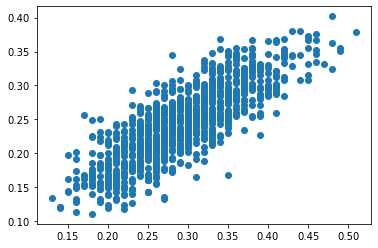

In [43]:
sim_list_test =list(map(JS_sim,repeat(JS_signature1),pair_list[:1000]))
true_sim_list_test =list(map(true_sim,repeat(matrix),pair_list[:1000]))
plt.scatter(sim_list_test,true_sim_list_test)

In [37]:
true=np.array(true_sim_list)
true[true>.5]

array([0.549217  , 0.549217  , 0.52521614, 0.52521614, 0.549217  ,
       0.52521614, 0.549217  , 0.549217  , 0.52521614, 0.549217  ,
       0.549217  , 0.52521614, 0.52521614, 0.52303228, 0.50353107,
       0.52303228, 0.50353107, 0.52303228, 0.50353107, 0.52303228,
       0.50353107, 0.52303228, 0.50353107, 0.52303228, 0.50353107,
       0.52303228, 0.50353107, 0.52303228, 0.50353107, 0.52303228,
       0.50353107, 0.52303228, 0.50353107, 0.549217  , 0.52521614,
       0.52303228, 0.549217  , 0.52521614, 0.52303228, 0.549217  ,
       0.52521614, 0.52303228, 0.549217  , 0.52521614, 0.52303228,
       0.549217  , 0.52521614, 0.52303228, 0.549217  , 0.52521614,
       0.52303228, 0.549217  , 0.52521614, 0.52303228, 0.549217  ,
       0.52521614, 0.52303228, 0.549217  , 0.52521614, 0.52303228,
       0.549217  , 0.52521614, 0.52303228, 0.549217  , 0.52521614,
       0.52303228, 0.549217  , 0.52521614, 0.52303228, 0.549217  ,
       0.52521614, 0.52303228, 0.549217  , 0.52521614, 0.52303

In [19]:
r = 5
for b in range (int(np.ceil(len(JS_signature)/r))):
    print('b',b)
    bucket,pairs = LSH_candidate(JS_signature1,b,r)
    pair_list = []
#     bucket2 = LSH_candidate_2(JS_signature,b,r)
#     print(bucket2)
    for key in pairs:
        begin = time.time()
        pair = unique_pairs_from_array(bucket[key])
        end = time.time()
        pair_list.append(pair)
        print('time1',end-begin)
     
    print(pair_list)

b 0
[]
b 1
time1 0.00012183189392089844
time1 7.843971252441406e-05
[array([[ 74, 140]]), array([[111, 152]])]
b 2
time1 0.00043201446533203125
time1 0.0001366138458251953
time1 6.985664367675781e-05
time1 8.0108642578125e-05
[array([[  7,  58],
       [  7, 112],
       [ 58, 112]]), array([[  7,  58],
       [  7, 112],
       [ 58, 112]]), array([[  6, 152]]), array([[ 57, 162]])]
b 3
[]
b 4
time1 0.00010895729064941406
time1 7.557868957519531e-05
time1 7.05718994140625e-05
time1 8.273124694824219e-05
time1 7.152557373046875e-05
[array([[37, 57]]), array([[ 4, 95]]), array([[  0, 116]]), array([[ 17, 142]]), array([[  2, 162]])]
b 5
time1 0.000110626220703125
time1 0.0001068115234375
time1 7.534027099609375e-05
time1 7.081031799316406e-05
time1 0.00012493133544921875
time1 0.00012969970703125
time1 0.0003216266632080078
time1 0.00031685829162597656
time1 0.00028967857360839844
time1 6.961822509765625e-05
time1 7.891654968261719e-05
time1 0.0004031658172607422
time1 7.05718994140625e

In [27]:
np.shape(JS_signature)

(100, 20)

In [39]:
a=np.array([2,3,1])
b=np.array([4,2,5])
print(a*b)
    

[8 6 5]


In [55]:
a =np.array([0,3,1,4,0,0,4,0])
per = np.random.permutation(len(a))
per_index = per.argsort()
print(per)
print(per_index)
print(a[per_index])
print(np.min(a[per_index].nonzero()[0]))

[0 6 4 1 5 2 3 7]
[0 3 5 6 2 4 1 7]
[0 4 0 4 1 0 3 0]
1


In [74]:
a=[0,0,4,5]
b=0
#while b==0:
for i in range (len(a)):
    print(i)
    if a[i]!=0:
        b=a[i]
        break
            
print(b)
            
            
# while sign[i][j] == np.inf:
#     for k in range (len(permutations[i])):
#         ## go through every line of the input matrix using permutation order
#         if input_matrix[j][per_index[k]] != 0:
#             sign[i][j] = k
#                 return
        

0
1
2
4


In [48]:
a=[]
if list(np.array[4,2,3]) in a:
    print("a")

TypeError: 'builtin_function_or_method' object is not subscriptable